# Read PtyRAD Output hdf5

- Created with PtyRAD 0.1.0b12
- Requires PtyRAD >= 0.1.0b8
- Latest demo params files / scripts: https://github.com/chiahao3/ptyrad/tree/main/demo
- Documentation: https://ptyrad.readthedocs.io/en/latest/
- PtyRAD paper: https://doi.org/10.1093/mam/ozaf070
- PtyRAD arXiv: https://arxiv.org/abs/2505.07814
- Zenodo record: https://doi.org/10.5281/zenodo.15273176
- Box folder: https://cornell.box.com/s/n5balzf88jixescp9l15ojx7di4xn1uo
- Youtube channel: https://www.youtube.com/@ptyrad_official

**Before running this notebook, you must first follow the instruction in `README.md` to:**
1. Create the Python environment with all dependant Python packages like PyTorch
2. Activate that python environment
3. Install `ptyrad` package into your activated Python environement (only need to install once)

> Note: This notebook is designed to demonstrate how to load the PtyRAD reconstructed model output from hdf5 files

Author: Chia-Hao Lee, cl2696@cornell.edu

## 00. Setup working directory and imports

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

# Set this to your desired working directory so you can easily access the data, model, param files
work_dir = "H:/workspace/ptyrad/demo/"

os.chdir(work_dir)
print("Current working dir: ", os.getcwd())
# Note that the output/ directory will be automatically generated under your working directory

Current working dir:  H:\workspace\ptyrad\demo


In [2]:
from ptyrad.load import load_ptyrad
from ptyrad.visualization import plot_scan_positions, plot_probe_modes, plot_loss_curves, plot_slice_thickness

## 01. Setup file path and load the output hdf5

In [3]:
model_path   = "output/tBL_WSe2/20250908_full_N16384_dp128_flipT100_random32_p6_1obj_1slice_plr1e-4_oalr5e-4_oplr5e-4_slr2e-3_orblur0.4_ozblur1.0_mamp0.03_4.0_oathr0.96_oposc_sng1.0_spr0.1/model_iter0200.hdf5"

# PtyRAD model output is just normal hdf5 file so you can open it just like normal hdf5
# But it's strongly recommended to use `load_ptyrad` to handle different data types, strings encoding, dicts, lists, and their nested structures for convenience 

ckpt         = load_ptyrad(model_path) # The loaded checkpoint (ckpt) is just a nested python dict

Success! Loaded .hdf5 file as a dict from path = 'output/tBL_WSe2/20250908_full_N16384_dp128_flipT100_random32_p6_1obj_1slice_plr1e-4_oalr5e-4_oplr5e-4_slr2e-3_orblur0.4_ozblur1.0_mamp0.03_4.0_oathr0.96_oposc_sng1.0_spr0.1/model_iter0200.hdf5'


## 02. Basic structure of the model output

In [4]:
print("ckpt: ")
for k in ckpt.keys():
    print('  ', k)

ckpt: 
   avg_iter_t
   avg_losses
   batch_losses
   dz_iters
   indices
   iter_times
   loss_iters
   model_attributes
   niter
   optim_state_dict
   optimizable_tensors
   output_path
   params
   ptyrad_version
   random_seed


- `model_attributes` contains important metadata for the ptychography forward model (i.e., propagator, dx, dk, crop positions, etc.)
- `optimizable_tensors` stores the AD-optimized tensors for object, probe, position, tilts, and thickness
- `params` keeps a copy of the loaded PtyRAD param

In [5]:
print(f'model_attributes: \n  {ckpt["model_attributes"].keys()}\n')
print(f'optimizable_tensors: \n  {ckpt["optimizable_tensors"].keys()}\n')
print(f'params: \n  {ckpt["params"].keys()}\n')

model_attributes: 
  dict_keys(['H', 'N_scan_fast', 'N_scan_slow', 'crop_pos', 'detector_blur_std', 'dk', 'dx', 'lr_params', 'obj_preblur_std', 'omode_occu', 'probe_int_sum', 'scan_affine', 'shift_probes', 'slice_thickness', 'start_iter', 'tilt_obj'])

optimizable_tensors: 
  dict_keys(['obj_tilts', 'obja', 'objp', 'probe', 'probe_pos_shifts', 'slice_thickness'])

params: 
  dict_keys(['constraint_params', 'hypertune_params', 'init_params', 'loss_params', 'model_params', 'params_path', 'recon_params'])



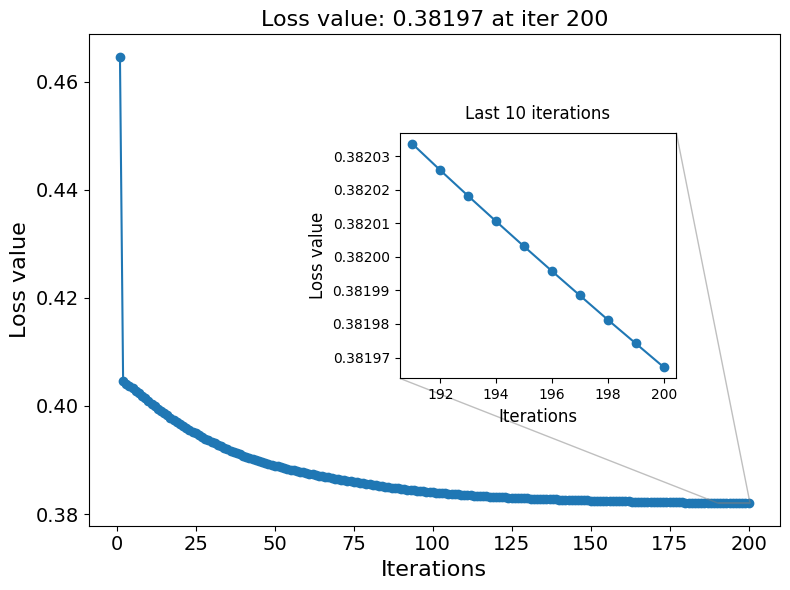

In [6]:
plot_loss_curves(ckpt['loss_iters'])

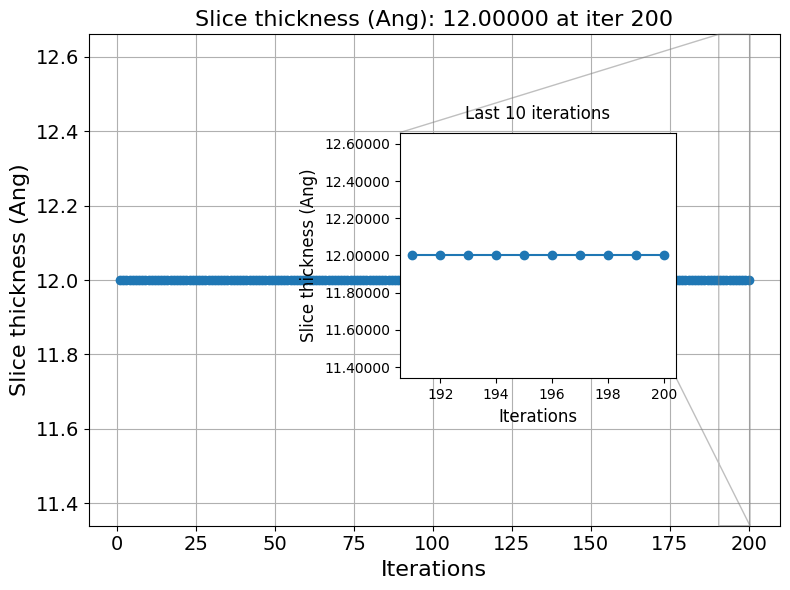

In [7]:
plot_slice_thickness(ckpt['dz_iters'])

## 03. Retrieve reconstructed obj, probe, positions

### 03.A Object

In [8]:
obja = ckpt['optimizable_tensors']['obja']
objp = ckpt['optimizable_tensors']['objp']
objc = obja * np.exp(1j*objp) # c for complex
print(objc.shape) # (omode, Nz, Ny, Nx)

(1, 1, 583, 583)


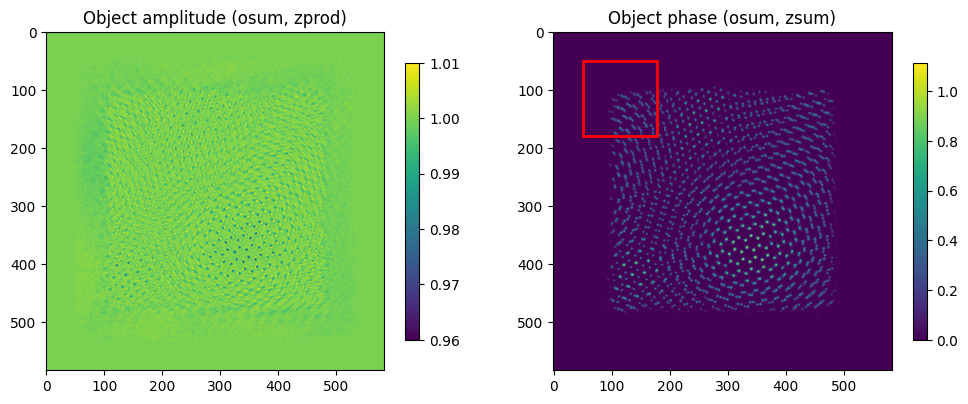

In [9]:
import matplotlib.patches as patches

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12,6))
im0 = axs[0].imshow(obja.sum(0).prod(0))
im1 = axs[1].imshow(objp.sum(0).sum(0))
fig.colorbar(im0, shrink=0.6)
fig.colorbar(im1, shrink=0.6)
axs[0].set_title('Object amplitude (osum, zprod)') # amplitude along depth is multiplicative
axs[1].set_title('Object phase (osum, zsum)')

# (x, y) is bottom-left corner in pixel coords, (w, h) is width/height
square = patches.Rectangle((50, 50), 128, 128, linewidth=2,
                           edgecolor='red', facecolor='none')
axs[1].add_patch(square)  # add to right image

plt.show()

# Note that there're blank spaces around the object because we'll need to fit the probe completely inside the object canvas for element-wise multiplication
# The red box denotes the probe window with the probe located in the center, see 03.C Position for more details about relative alignment

### 03.B Probe

In [10]:
probe = ckpt['optimizable_tensors']['probe']
print(probe.shape) # (pmode, Ny, Nx), note that probe is stored as complex-valued probe wavefunction in real space, locating in the window center

(6, 128, 128)


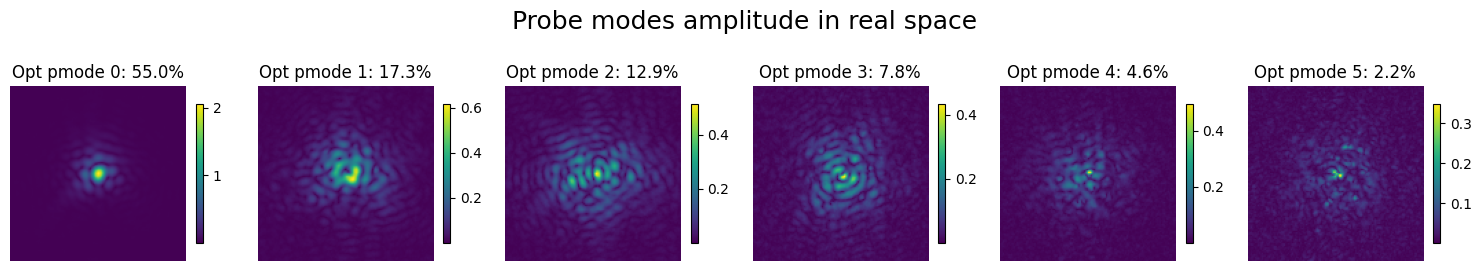

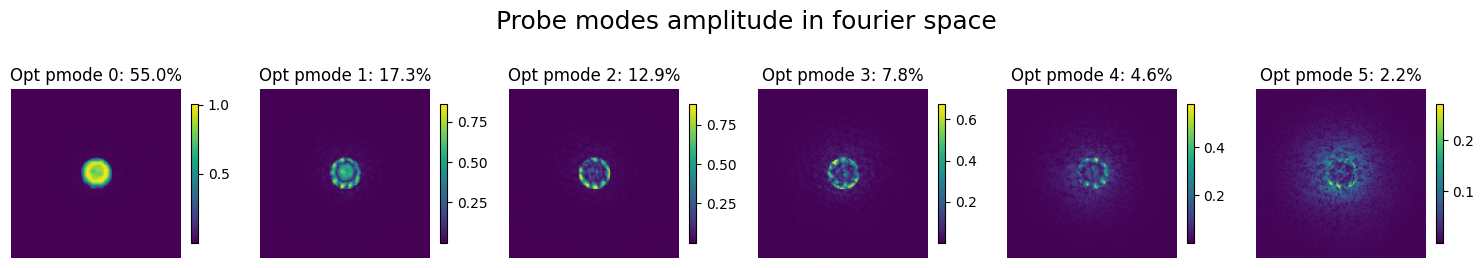

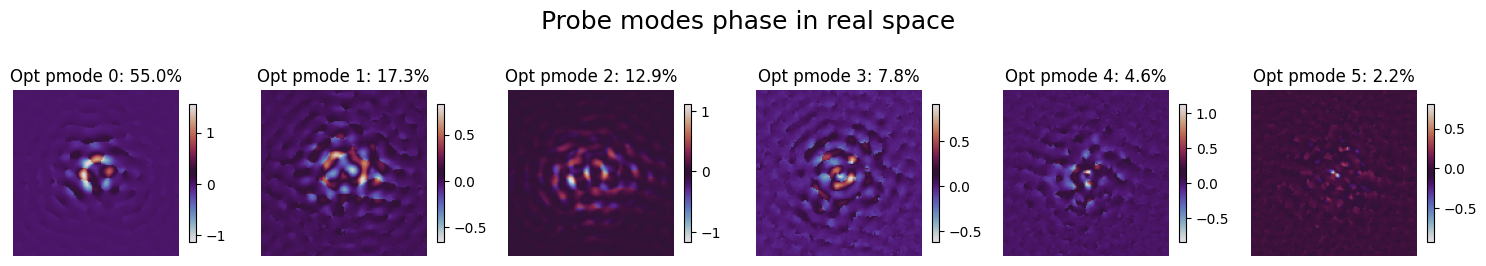

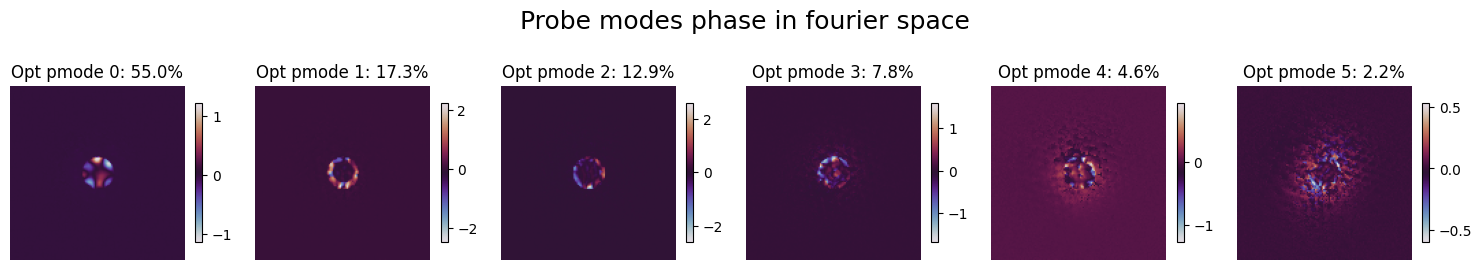

In [11]:
plot_probe_modes(opt_probe=probe, amp_or_phase='amplitude', real_or_fourier='real')
plot_probe_modes(opt_probe=probe, amp_or_phase='amplitude', real_or_fourier='fourier')
plot_probe_modes(opt_probe=probe, amp_or_phase='phase', real_or_fourier='real')
plot_probe_modes(opt_probe=probe, amp_or_phase='phase', real_or_fourier='fourier')

### 03.C Probe position

In [12]:
crop_pos = ckpt['model_attributes']['crop_pos']
probe_pos_shifts = ckpt['optimizable_tensors']['probe_pos_shifts']
pos = crop_pos + probe_pos_shifts # In unit of real space object px
print(pos.shape)

# Note that crop_pos is a fixed array with integer values. PtyRAD only optimizes sub-px position shifts relative to these initial crop_pos.
# pos is defined at the top-left corner of the probe window, so there's an offset of (Npix/2, Npix/2) between the cropping position, and the actual probe position on object

(16384, 2)


In [13]:
crop_pos

array([[ 49,  49],
       [ 49,  52],
       [ 49,  55],
       ...,
       [407, 401],
       [407, 404],
       [407, 407]], dtype=int32)

In [14]:
probe_pos_shifts

array([[ 0.67257774,  3.2575853 ],
       [ 1.6509179 ,  2.3556314 ],
       [ 3.1341972 ,  3.66328   ],
       ...,
       [-2.4141347 , -3.514011  ],
       [-3.0580354 , -2.7943096 ],
       [-2.6611648 , -3.638554  ]], dtype=float32)

In [15]:
pos

array([[ 49.67257774,  52.25758529],
       [ 50.65091789,  54.35563135],
       [ 52.13419724,  58.66328001],
       ...,
       [404.58586526, 397.48598909],
       [403.94196463, 401.20569038],
       [404.33883524, 403.3614459 ]])

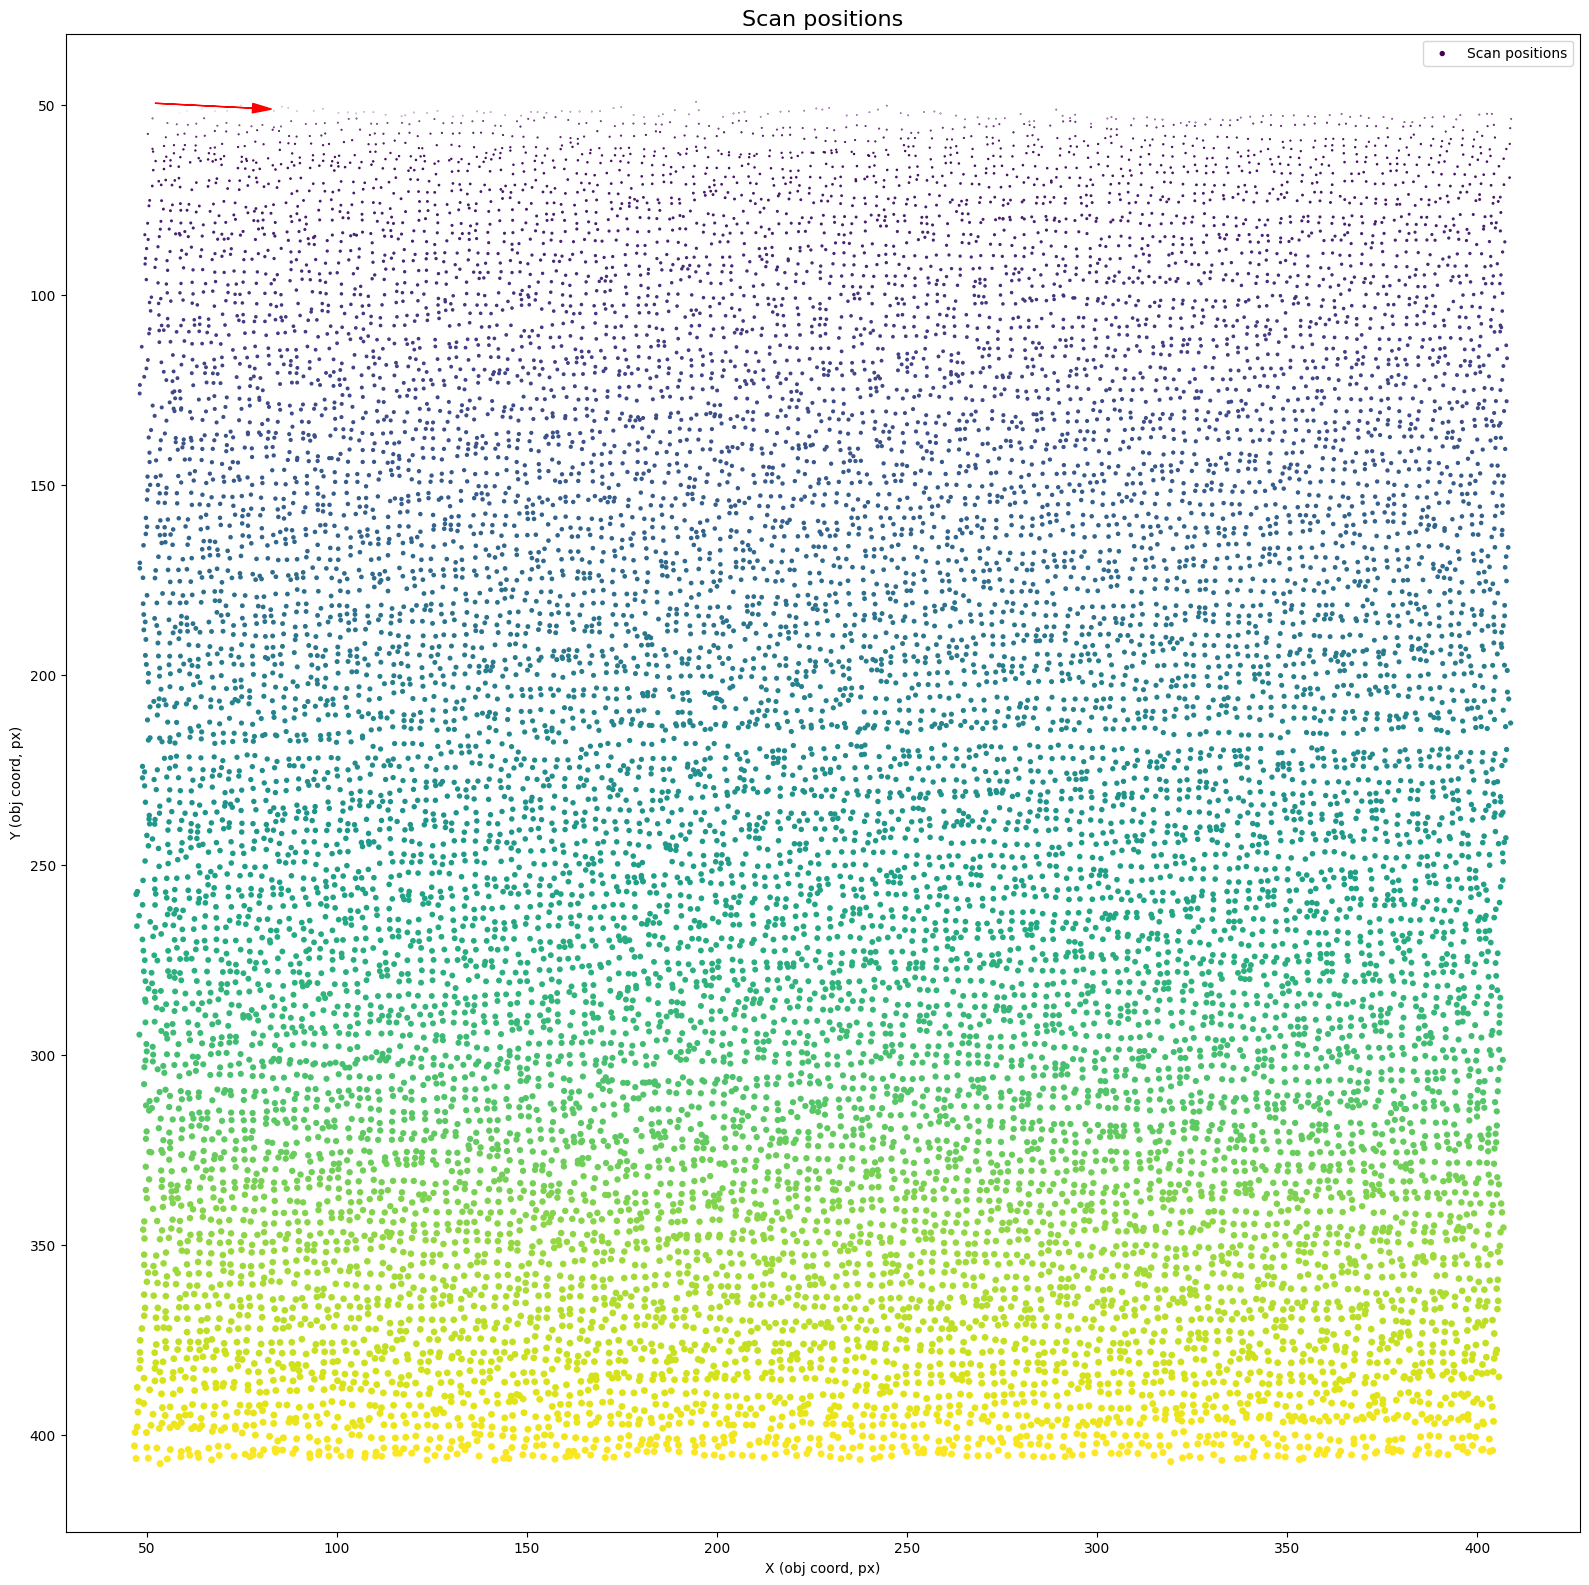

In [16]:
plot_scan_positions(pos)

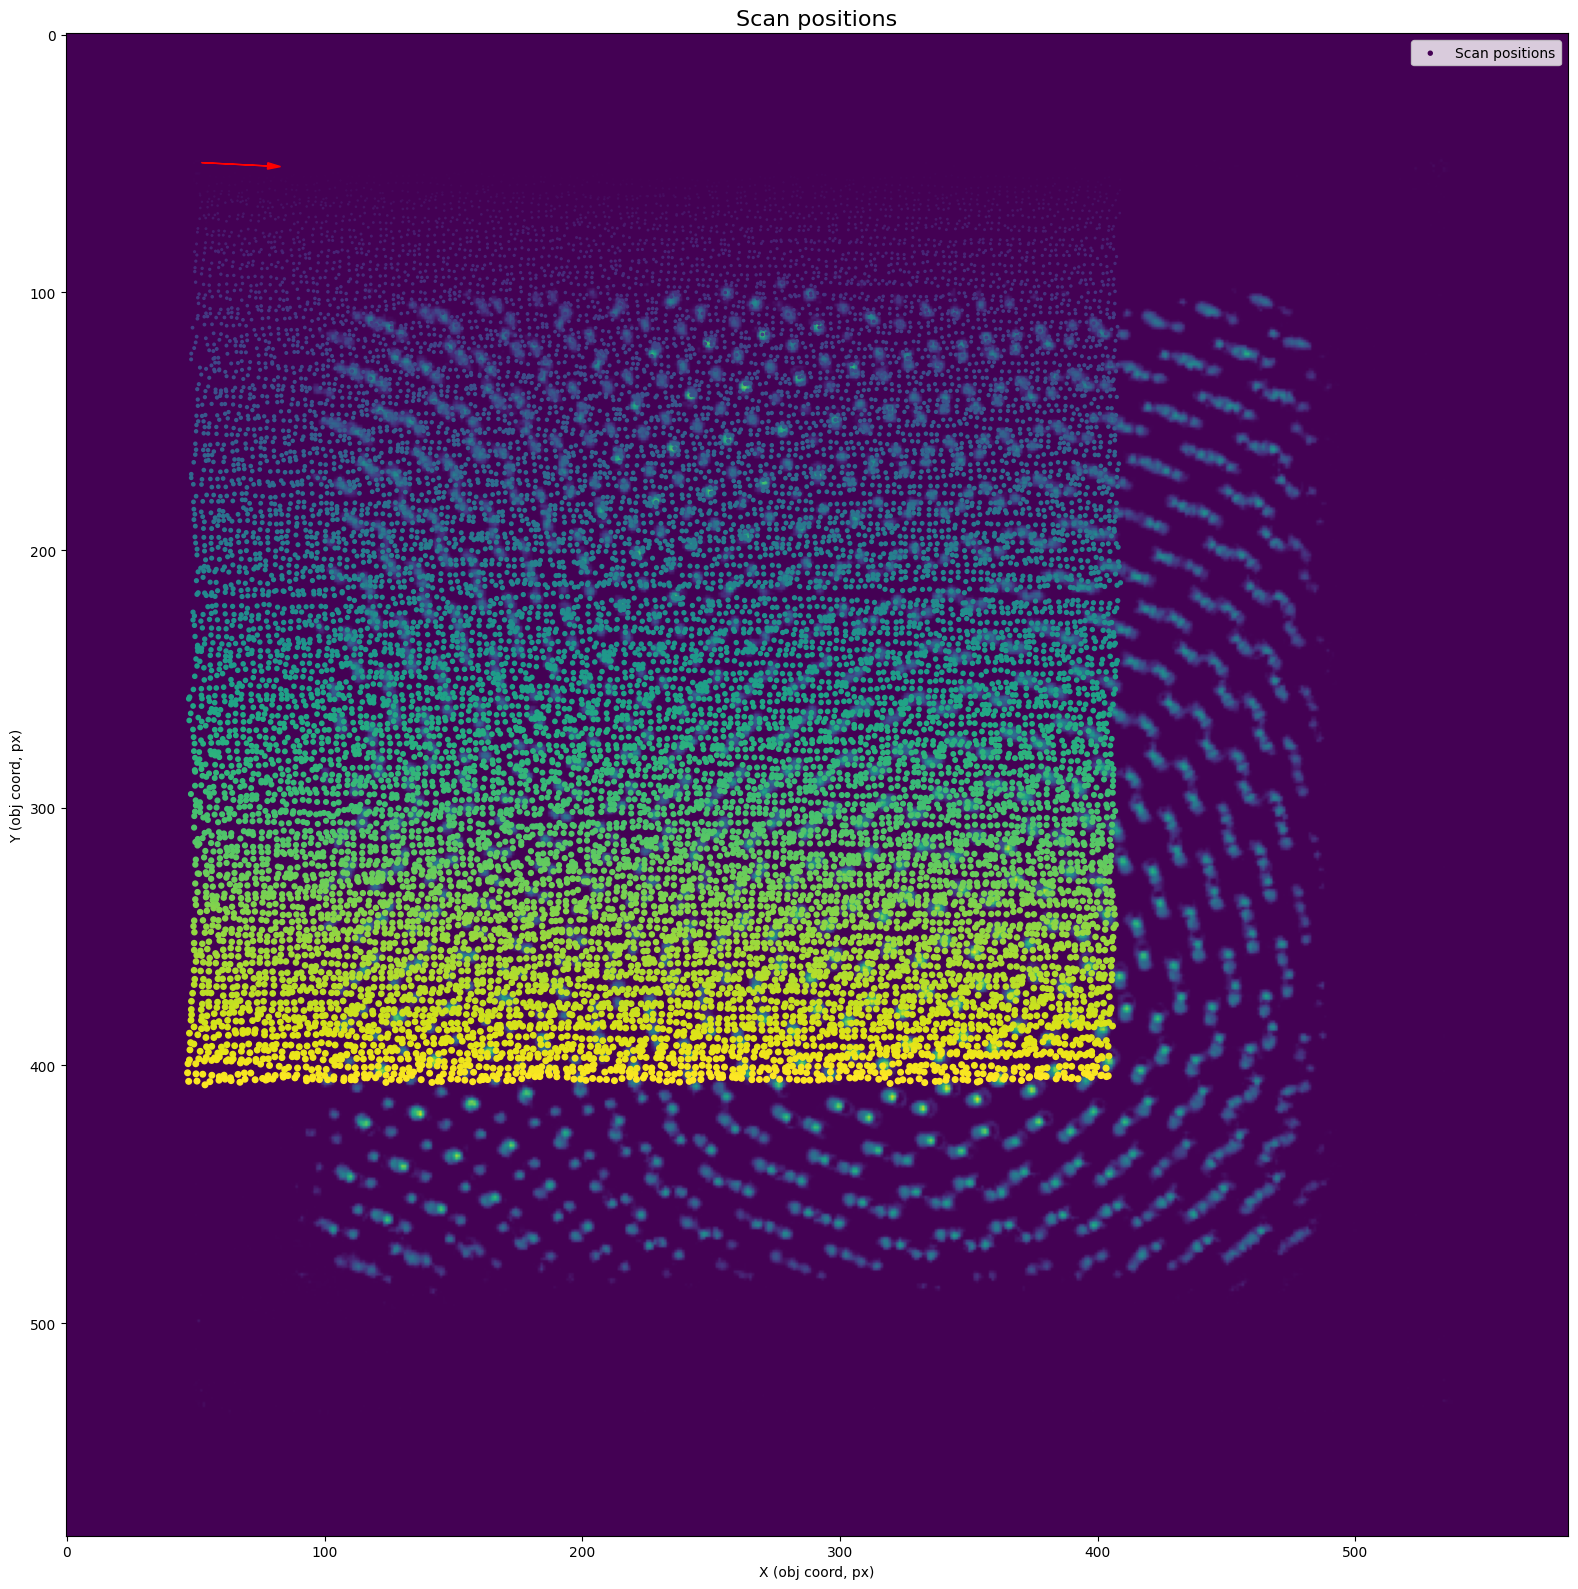

In [17]:
plot_scan_positions(pos, img=objp.sum(0).sum(0), offset=(0,0)) # The scatter points denote the "cropping position", which are the top-left corner of the each probe windows

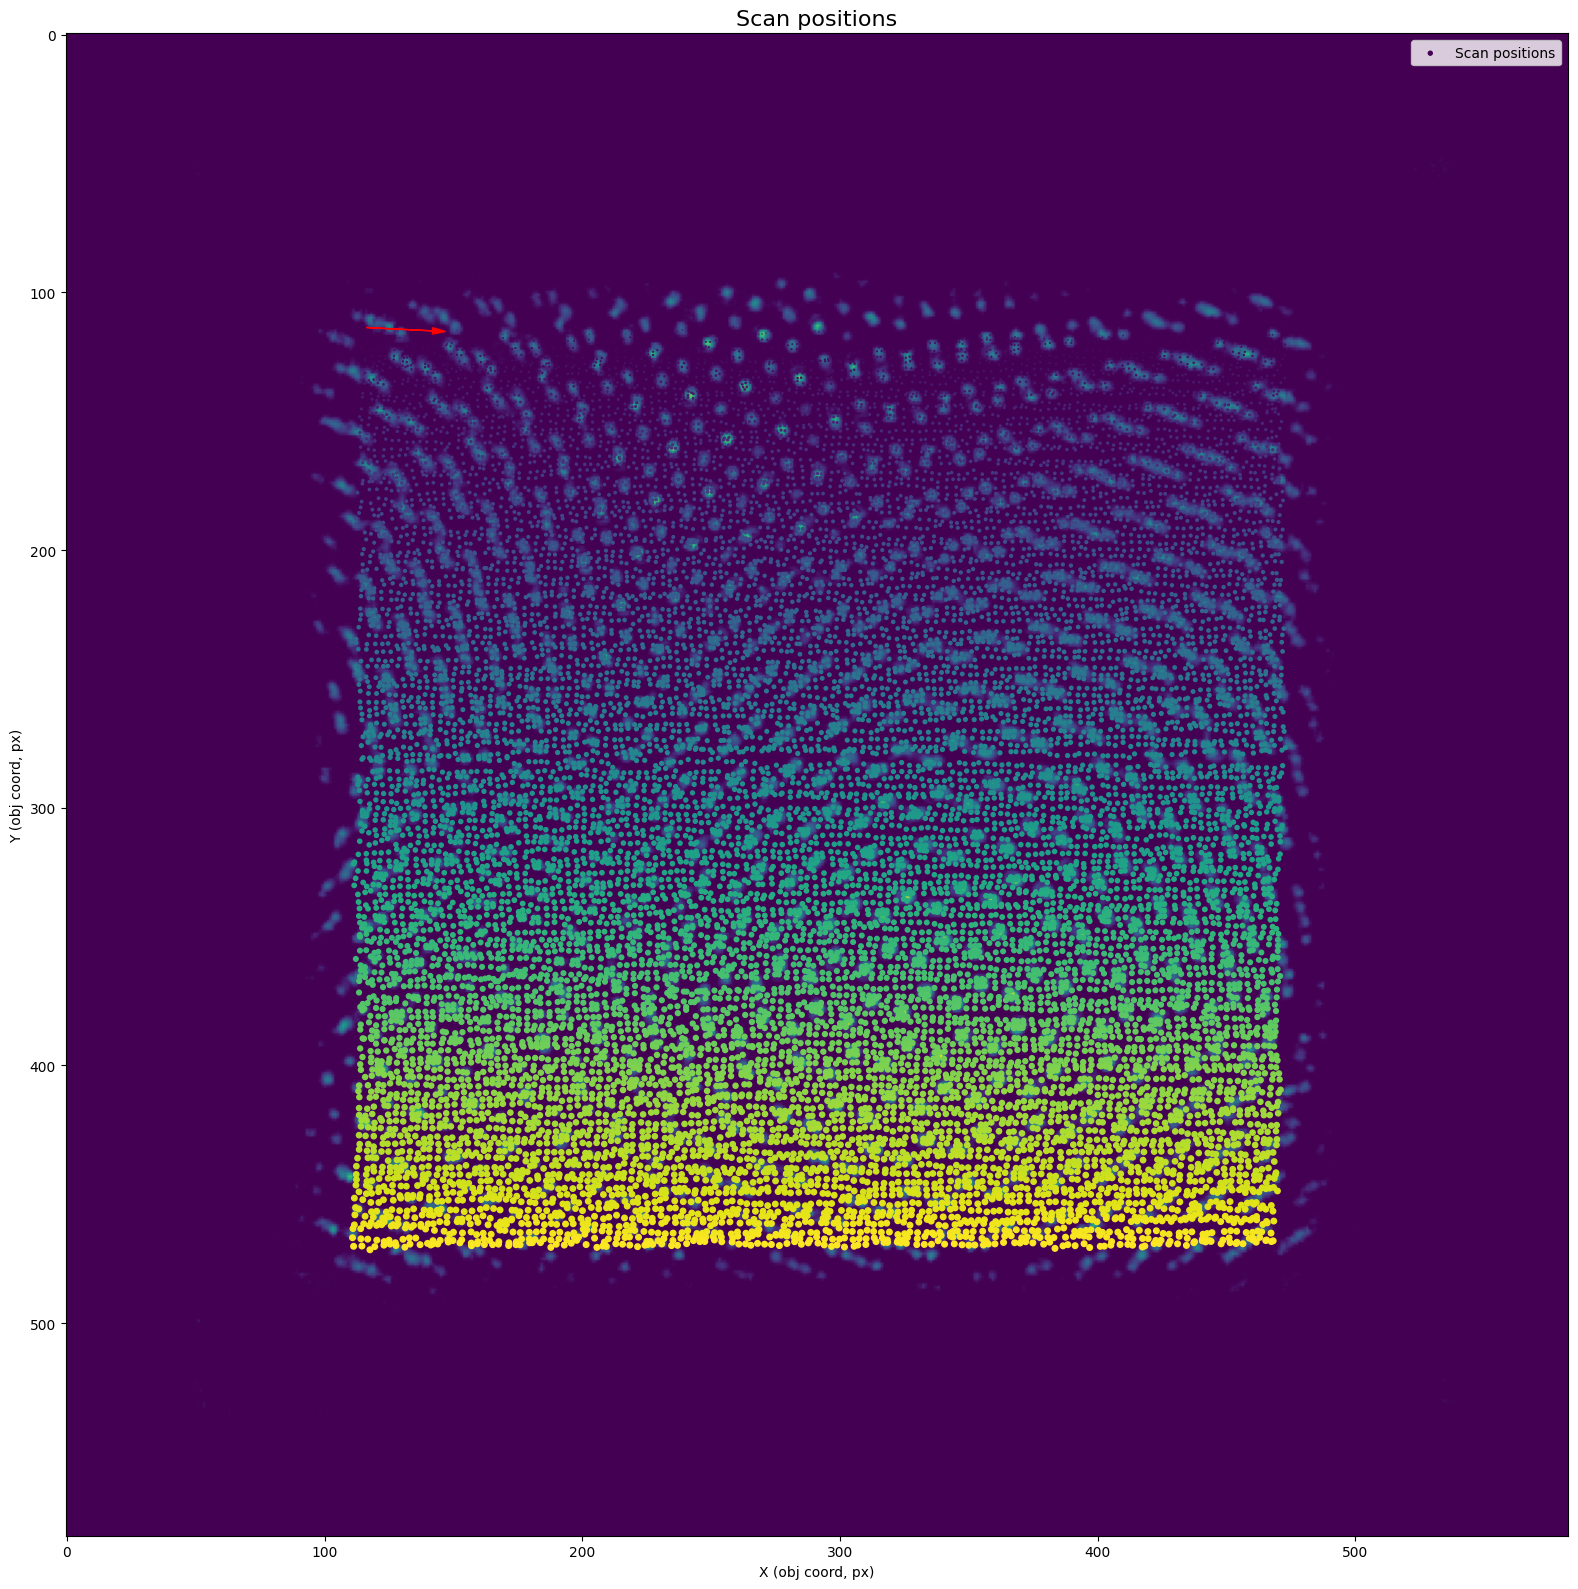

In [18]:
plot_scan_positions(pos, img=objp.sum(0).sum(0), offset=np.array(probe.shape[1:])/2) # The scatter points now denote the actual probe positions on object

### 03.D Crop object by the scanning FOV

In [19]:
img_crop_pos = crop_pos + np.array(probe.shape[-2:])//2
y_min, y_max = img_crop_pos[:,0].min(), img_crop_pos[:,0].max()
x_min, x_max = img_crop_pos[:,1].min(), img_crop_pos[:,1].max()

objp_crop = objp[:, :, y_min-1:y_max, x_min-1:x_max]
obja_crop = obja[:, :, y_min-1:y_max, x_min-1:x_max]

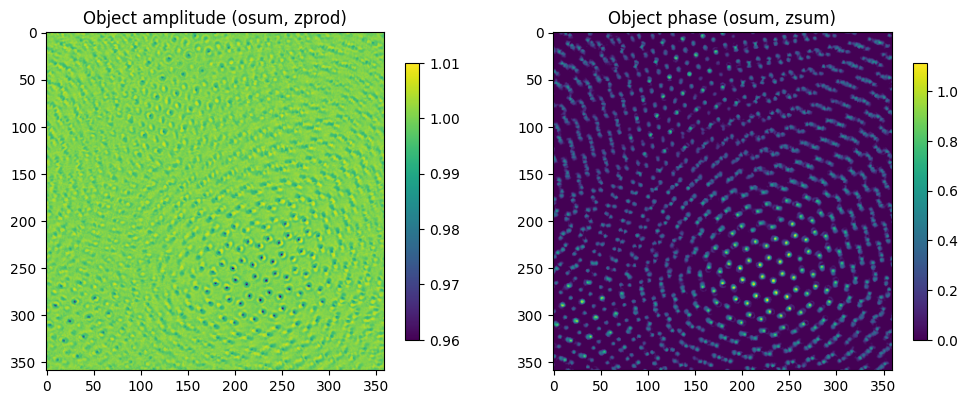

In [20]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12,6))
im0 = axs[0].imshow(obja_crop.sum(0).prod(0))
im1 = axs[1].imshow(objp_crop.sum(0).sum(0))
fig.colorbar(im0, shrink=0.6)
fig.colorbar(im1, shrink=0.6)
axs[0].set_title('Object amplitude (osum, zprod)') # amplitude along depth is multiplicative
axs[1].set_title('Object phase (osum, zsum)')
plt.show()